In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import numba, os, sys, time, pickle, resource, copy
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from sys import path

from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
import importlib

base_path = "../" # Replace this with the path you want CROBAR putting files.
path.append(base_path+'python_modules')
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission
sdo_data_dir = os.path.join(base_path,"data")

plt.rcParams.update({'font.size': 18,'figure.figsize':[20,12],'image.origin':'lower'})

/tmp/ipykernel_61613/3923183416.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
#date='2010/07/25 00:16:30' # The date to use
#datestr='20100725_001630' # A string describing the date for save file purposes
length_unit = u.cm

date='2021/12/27 02:00:00'
datestr = '20211227_020000'

# Voxel size for CROBAR (0.42 Mm here)
dvox = np.array([(0.42*u.Mm).to(length_unit).value]*3)

# Voxel size for initial points:
flt_dvox = dvox*[1.0,1.0,10.0] # Initial point filtering voxel size
nloops_vol = 50 # Number of initial point randomly selected in the volume
nloops_flux = 1000 # Number of flux weighted initial points

# Value of force-free alpha to use for field line tracing:
alpha = -5/1.0e11 #*np.mean(1.0/(bounds0[1,0:2]-bounds0[0,0:2])**2)**0.5
alphastr = str(round(alpha/1.0e-11,3))

psf_size_px = 0.7 # Default PSF size in pixels
min_height = 1.0*dvox[2] # Loops must rise at least this high
min_length = 8.0*np.mean(dvox) # Loops must be at least this long

# Start tracing this high above the solar surface:
ivp_z0 = 0.02*dvox[2]
ivp_xpo = 1.0
ivp_clip = 0.99

download = False # Download from VSO
newpoints = 1 # Generate new seed points
newtrace = 1 # Retrace field lines

# Save footpoints to this file
footpoint_savefile = os.path.join(sdo_data_dir,'footpoints_'+datestr+'.pickle')
# Save traced loops to this file:
loop_savefile = os.path.join(sdo_data_dir,'loops_'+datestr+'_'+alphastr+'.pickle')

# X and y range of solar images to use for SDO/STEREO:
[x0, y0, xsz0, ysz0] = [-150, 235, 400, 350]
[xl, yl, xh, yh] = [x0, y0, x0+xsz0, y0+ysz0]
# X and Y ranges for STEREO A and B:
[xl_sta, xh_sta, yl_sta, yh_sta] = [-1200, -600, -650, -250]
[xl_stb, xh_stb, yl_stb, yh_stb] = [600, 1200, -650, -250]

# Voxels are padded inward from the crop range by this much:
vox_boundpad = np.array([[0.05,0.05,0.001],[-0.05,-0.05,-0.1]])
# Initial points are padded inward from the crop range by this much:
ivp_boundpad = np.array([[0.05,0.05,0.075],[-0.05,-0.05,-0.7]])

scaltemp1 = 1.2e6 # Temperature for estimating scale height of loop profile 1
scaltemp2 = 1.2e6 # Temperature for estimating scale height of loop profile 2
chan1_xpo = 2.0 # Assumed exponential power law index of the temperature response function
zmin0 = 2.63e8 # Minimum height

In [5]:
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
nloops0 = nloops_vol+nloops_flux
flux_factor = dvox[0]*dvox[1]
gfac = 1.0/2.2
length_unit = u.cm

# Massaging the x and y ranges:
cropr_stereoa = [xl_sta,xh_sta,yl_sta,yh_sta]*u.arcsec
cropr_stereob = [xl_stb,xh_stb,yl_stb,yh_stb]*u.arcsec
cropr = [x0-xsz0*(vox_boundpad[0,0]/(1-vox_boundpad[0,0])),x0+xsz0/(1+vox_boundpad[1,0]),
        y0-ysz0*(vox_boundpad[0,1]/(1-vox_boundpad[0,1])),y0+ysz0/(1+vox_boundpad[1,1])]*u.arcsec
cropr0 = [x0, x0+xsz0, y0, y0+ysz0]*u.arcsec

In [6]:
if(download):
    # Download fresh from the VSO:
    #time_range = TimeRange(TimeRange(date,-1800*u.s).start,TimeRange(date,1800*u.s).end)
    #qry_stereo = Fido.search(a.Time(time_range),a.Instrument('SECCHI'),a.Wavelength(284*u.angstrom))
    #sta_hits = search_fido_response(qry_stereo,'STEREO_A')[0]
    #stereoadat_path = Fido.fetch(qry_stereo[sta_hits[0],sta_hits[1]],path=sdo_data_dir)
    #print(stereoadat_path)

    #stb_hits = search_fido_response(qry_stereo,'STEREO_B')[0]
    #stereobdat_path = Fido.fetch(qry_stereo[stb_hits[0],stb_hits[1]],path=sdo_data_dir)
    #print(stereobdat_path)

    time_range = TimeRange(TimeRange(date,-10*u.s).start,TimeRange(date,10*u.s).end)
    qry_aia335 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(335*u.angstrom))
    aia335dat_path = Fido.fetch(qry_aia335[0][0],path=sdo_data_dir)[0]

    time_range = TimeRange(TimeRange(date,-10*u.s).start,TimeRange(date,10*u.s).end)
    qry_aia171 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(171*u.angstrom))
    aia171dat_path = Fido.fetch(qry_aia171[0][0],path=sdo_data_dir)[0]

    time_range = TimeRange(TimeRange(date,-60*u.s).start,TimeRange(date,60*u.s).end)
    qry_hmi = Fido.search(a.Time(time_range),a.Instrument('HMI'),a.Physobs('LOS_magnetic_field'))
    magnetogram_path = Fido.fetch(qry_hmi[0][0],path=sdo_data_dir)[0]
else:
    # These filenames may be need to be updated if its redownloaded or other data is used:
    #stereoadat_path = os.path.join(sdo_data_dir,'20100725_001630_n4eua.fts')
    #stereobdat_path = os.path.join(sdo_data_dir,'20100725_001630_n4eub.fts')
    aia335dat_path = os.path.join(sdo_data_dir,'aia_lev1_335a_2021_12_27t02_00_00_62z_image_lev1.fits')
    aia171dat_path = os.path.join(sdo_data_dir,'aia_lev1_171a_2021_12_27t01_59_57_34z_image_lev1.fits')
    magnetogram_path = os.path.join(sdo_data_dir,'hmi_m_45s_2021_12_27_02_01_30_tai_magnetogram.fits')

In [7]:
aiadat_path = aia335dat_path
print(aia335dat_path,aia171dat_path,magnetogram_path)

../data/aia_lev1_335a_2021_12_27t02_00_00_62z_image_lev1.fits ../data/aia_lev1_171a_2021_12_27t01_59_57_34z_image_lev1.fits ../data/hmi_m_45s_2021_12_27_02_01_30_tai_magnetogram.fits


In [8]:
# Load and crop the magnetogram:
magnetogram = Map(magnetogram_path)#.rotate(order=3)
blc=SkyCoord(cropr[0],cropr[2],frame=magnetogram.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=magnetogram.coordinate_frame)
magnetogram = magnetogram.submap(blc,top_right=trc)

# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram,lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

rsun_cm = magnetogram.center.rsun.to(length_unit).value

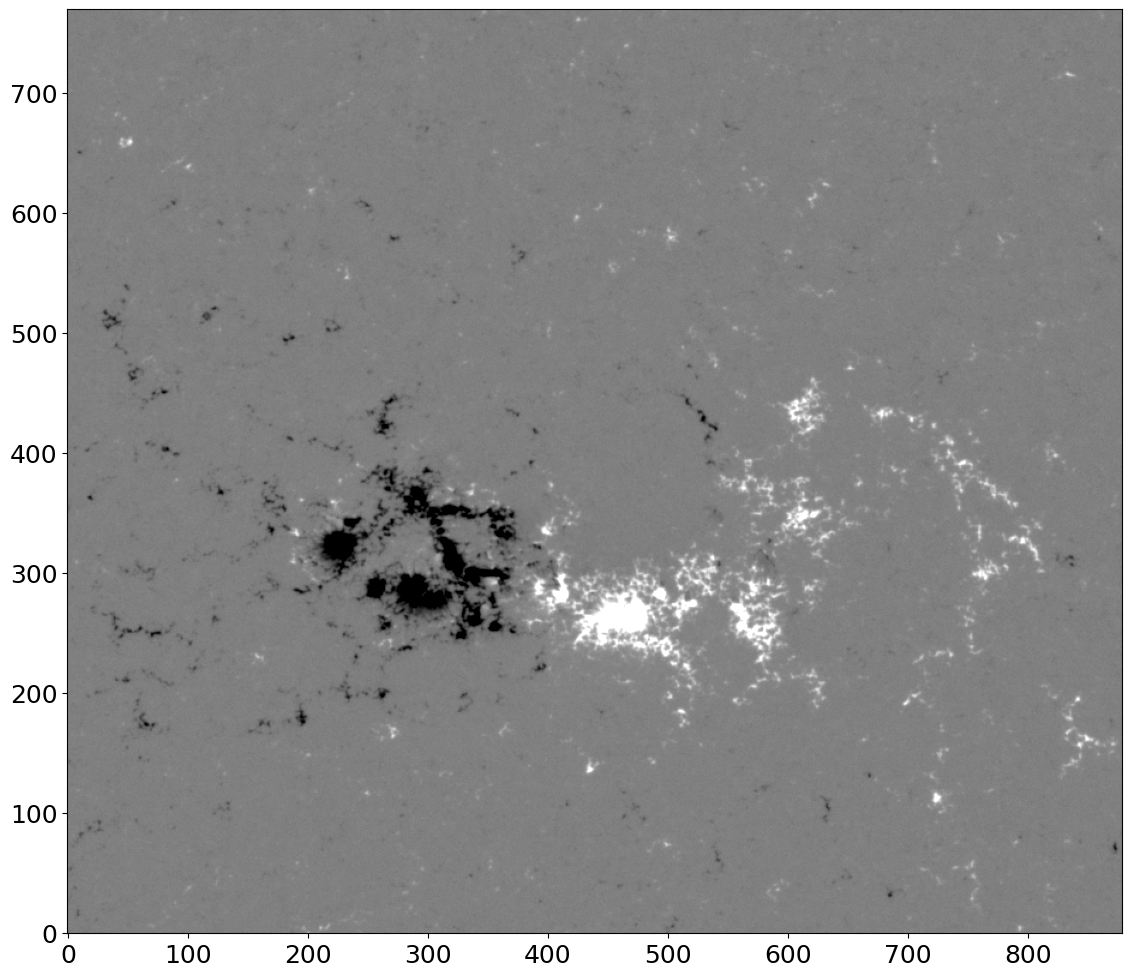

In [9]:
plt.imshow(np.flipud(np.fliplr(magnetogram.data)),cmap=plt.get_cmap('gray'),vmin=-500,vmax=500)

In [10]:
# Set up boundaries for overall region:
bounds0 = np.array([[np.min(c),np.max(c)] for c in mag_coords]).T
bounds0[1,2] = bounds0[0,2] + 0.625*np.min(bounds0[1,0:2]-bounds0[0,0:2])

heights = (mag_coords[0]**2+mag_coords[1]**2+(rsun_cm+mag_coords[2])**2)**0.5 - rsun_cm

# Boundaries for field line tracing are set slightly larger to avoid
# issues when an initial point falls outside the boundary:
tracer_bounds = copy.deepcopy(bounds0)
tracer_bounds[0,0] -= 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[0,1] -= 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[1,0] += 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[1,1] += 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[0,2] = np.max(heights)
tracer_bounds[1,2] = tracer_bounds[0,2] + bounds0[1,2]-bounds0[0,2] # np.max(mag_coords[2,:,:,:]) - bounds0[0,2]

# Get coordinate grids (see coord_grid.py for details of these)
def bounds2grid(bounds0,dvox,offsets=None,pad=None,frame=None):
    if(offsets is None): offsets = 0.5+0.0*dvox
    if(pad is None): pad = np.zeros([2,len(dvox)])
    if(frame is None): frame = np.arange(len(dvox))
    bounds = bounds0+pad*(bounds0[1]-bounds0[0])
    nvox = np.floor((bounds[1]-bounds[0])/dvox).astype(np.int32)
    vox_origin = bounds[0]+offsets*(bounds[1]-bounds[0]-nvox*dvox)
    return coord_grid(nvox,vox_origin,np.diag(dvox),frame)

# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,dvox,offsets=[0.5,0.5,0.0],pad=vox_boundpad)
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,flt_dvox,offsets=[0.5,0.5,0.0])

In [11]:
# Field values and coordinates used for tracing the magnetogram 
# (commented out code will bin it down by a factor of 2, but largely not needed with the MDI 
# magnetogram used in this example):
mag_trace = bindown2(mag[:,:,0],2)/4
mag_coords_trace = np.array([bindown2(xa[:,:,0],2)/4 for xa in mag_coords])

In [13]:
if(newpoints):
    ivp_bounds = tracer_bounds+ivp_boundpad*(tracer_bounds[1]-tracer_bounds[0])
    volume_initial_points = volume_seed_points(nloops_vol, ivp_bounds)
    #fluxw_initial_points = fluxweighted_seed_points2(nloops_flux, mag, mag_coords, ivp_bounds, z0=ivp_z0, xpo=ivp_xpo, clip=ivp_clip)
    fluxw_initial_points = hilbert_seed_points(nloops_flux, mag, mag_coords, ivp_z0, rsun=rsun_cm)
    initialpoint_dict = {'xydomain':[x0,y0,xsz0,ysz0], 'vox_boundpad':vox_boundpad, 'ivp_boundpad':ivp_boundpad, 
                         'dvox':dvox, 'min_height':min_height, 'min_length':min_length, 'magnetogram_path':magnetogram_path, 
                         'date':date, 'datestr':datestr, 'magnetogram':magnetogram, 'mag':mag, 'mag_coords':mag_coords,
                         'ivp_bounds':ivp_bounds, 'ivp_z0':ivp_z0, 'ivp_xpo':ivp_xpo, 'ivp_clip':ivp_clip, 'cropr':cropr,
                         'cropr0':cropr0, 'vox_grid':vox_grid, 'volume_initial_points':volume_initial_points, 
                         'fluxw_initial_points':fluxw_initial_points, 'flt_grid':flt_grid}

    filehandler = open(footpoint_savefile,"wb")
    pickle.dump(initialpoint_dict,filehandler)
    filehandler.close()
if(not(newpoints)):
    file = open(footpoint_savefile,'rb')
    initialpoint_dict = pickle.load(file)
    file.close()
    fluxw_initial_points = initialpoint_dict['fluxw_initial_points']
    volume_initial_points = initialpoint_dict['volume_initial_points']
    ivp_bounds = initialpoint_dict['ivp_bounds']
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [14]:
# Plot the initial points over the magnetogram:
fluxw_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in fluxw_initial_points]
volume_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in volume_initial_points]

fluxw_initial_pt_pix = np.vstack(fluxw_initial_pt_pix)
volume_initial_pt_pix = np.vstack(volume_initial_pt_pix)

(0.0, 770.0)

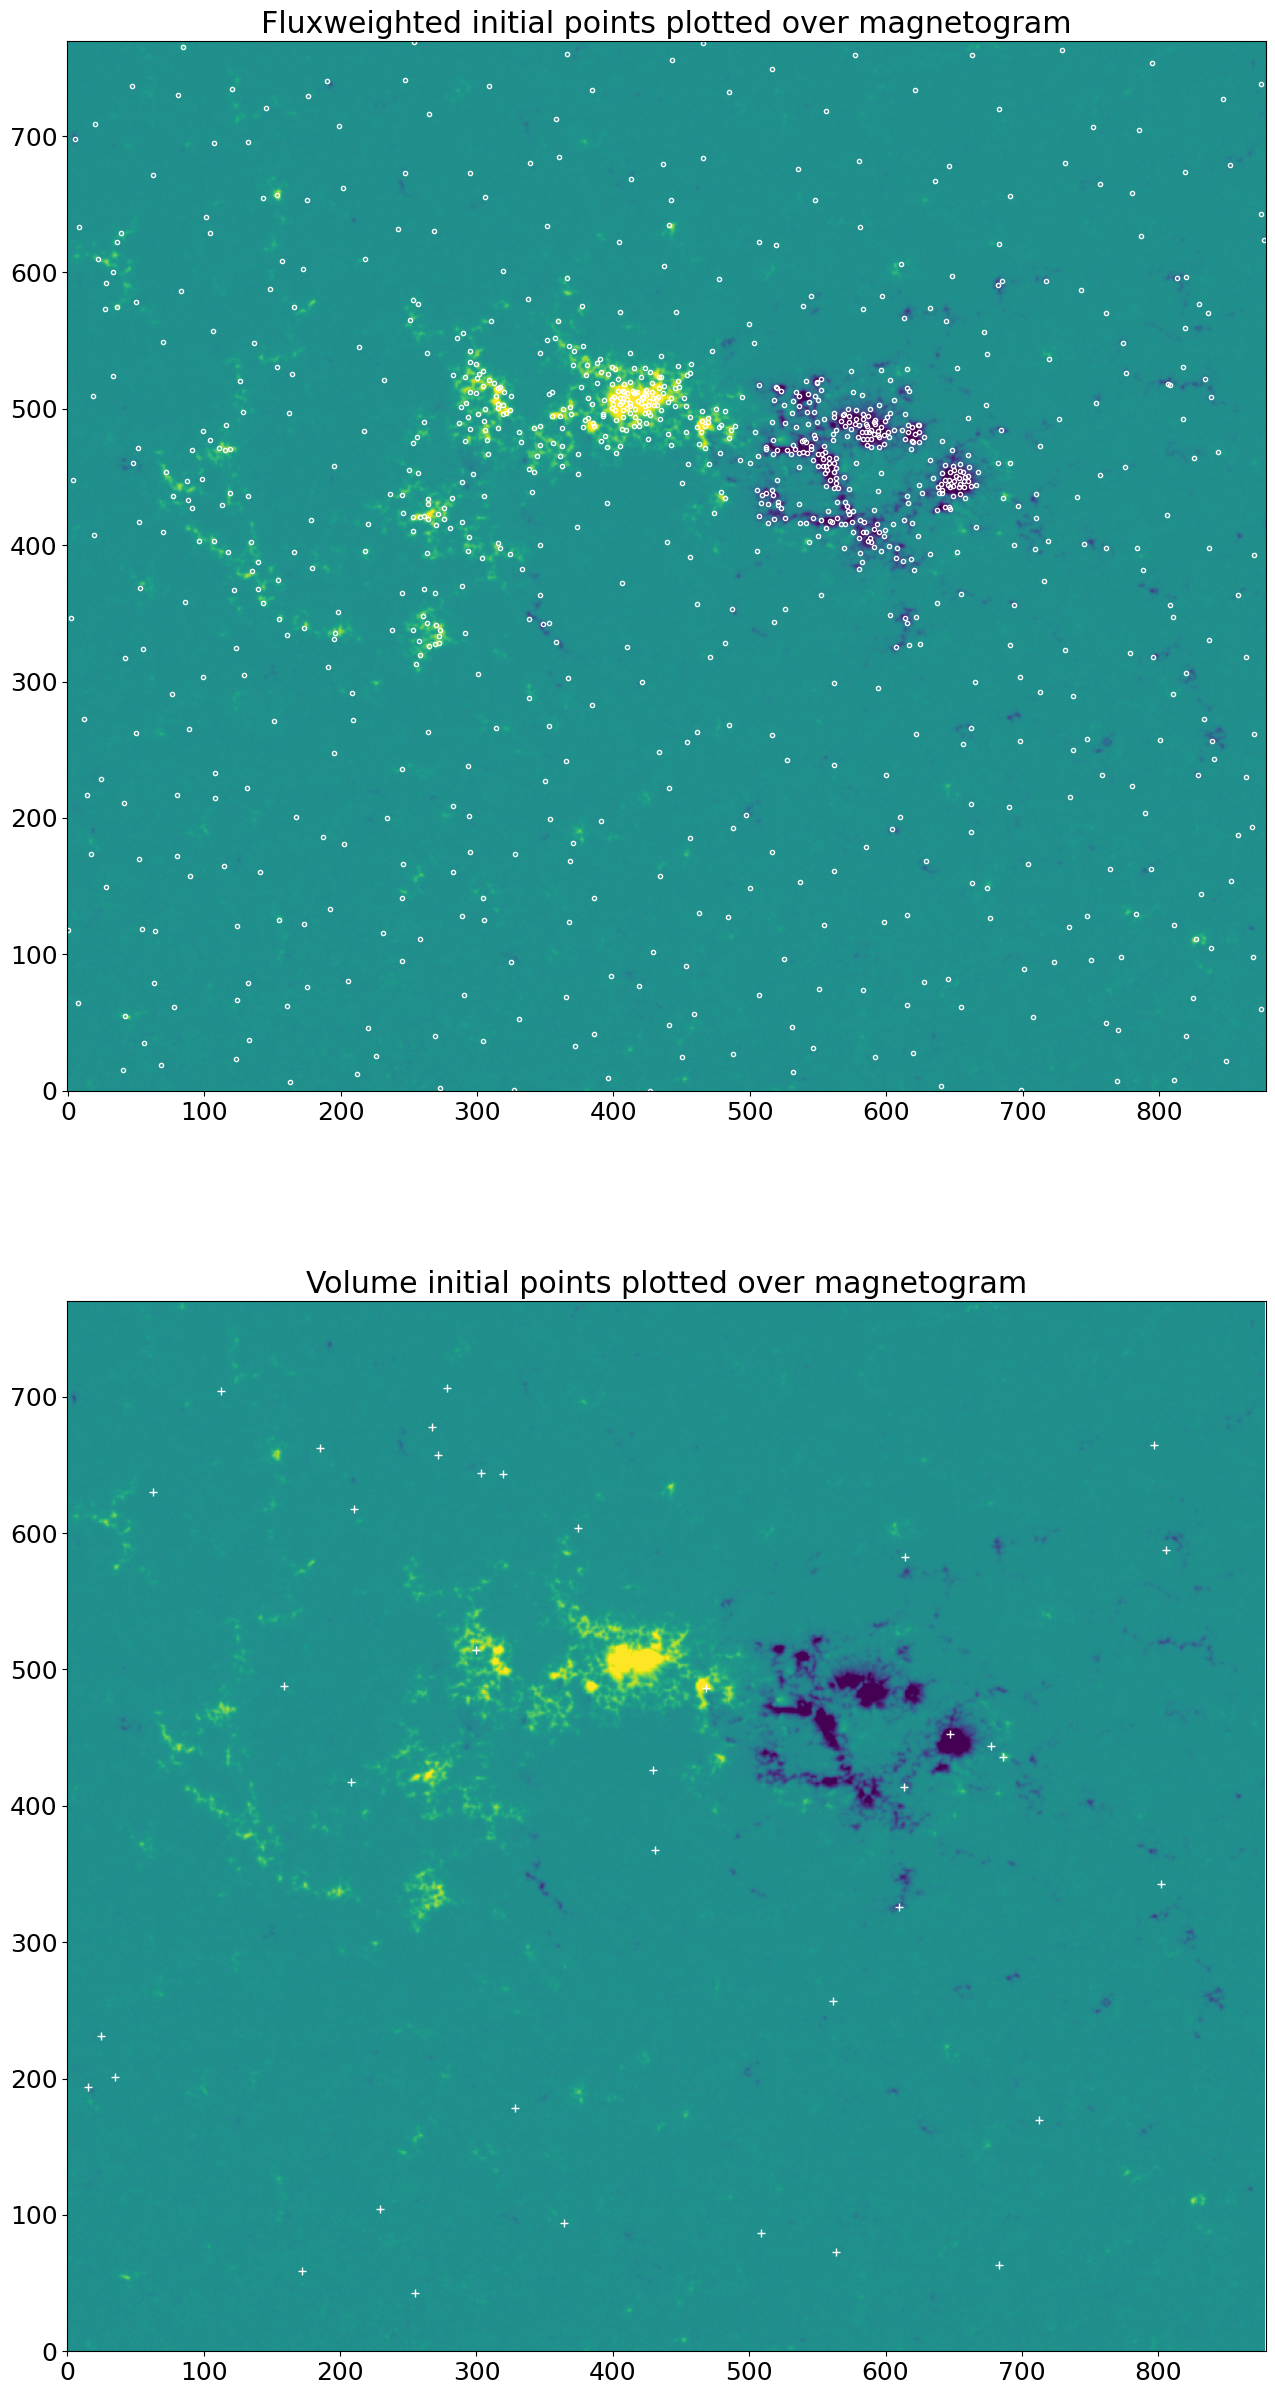

In [15]:
fig = plt.figure(figsize=[25,30])
extent = np.array([bounds0[0,0],bounds0[1,0],bounds0[0,1],bounds0[1,1]])/1.0e8

ax1 = fig.add_subplot(2,1,1)
ax1.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax1.plot(fluxw_initial_pt_pix[:,1],fluxw_initial_pt_pix[:,0],'.',color='white', markerfacecolor='none')
ax1.set(title='Fluxweighted initial points plotted over magnetogram')

ax2 = fig.add_subplot(2,1,2)
ax2.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax2.plot(volume_initial_pt_pix[:,1],volume_initial_pt_pix[:,0],'+',color='white')
ax2.set(title='Volume initial points plotted over magnetogram')
plt.xlim(0,mag.shape[1])
plt.ylim(0,mag.shape[0])

In [16]:
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [18]:
# Trace field lines if newtrace is true:
if(newtrace):
    fieldlines = forcefree_field.tracer(use_points, mag_trace, mag_coords_trace, bounds=tracer_bounds, alpha=alpha, rtol=1.0e-5,atol=0.001*dvox[0], boundrad=magnetogram.center.rsun.to(u.cm).value)
    filehandler = open(loop_savefile,"wb")
    pickle.dump(fieldlines,filehandler)
    filehandler.close()
# Otherwise reload from the previously specified file:
if(newtrace==0):
    file = open(loop_savefile,'rb')
    fieldlines = pickle.load(file)
    file.close()


Done with line  49  at  27.081778287887573  s
Done with line  99  at  36.21237349510193  s
Done with line  149  at  49.36360573768616  s
Done with line  199  at  68.28043627738953  s
Done with line  249  at  98.96210813522339  s
Done with line  299  at  130.60920572280884  s
Done with line  349  at  166.7995593547821  s
Done with line  399  at  192.68833541870117  s
Done with line  449  at  207.66383171081543  s
Done with line  499  at  225.63048362731934  s
Done with line  549  at  248.10603499412537  s
Done with line  599  at  274.7604248523712  s
Done with line  649  at  303.125869512558  s
Done with line  699  at  361.6040909290314  s
Done with line  749  at  402.6630597114563  s
Done with line  799  at  438.79218769073486  s
Done with line  849  at  477.70596861839294  s
Done with line  899  at  499.6009223461151  s
Done with line  949  at  539.2922356128693  s
Done with line  999  at  576.059469461441  s
Done with line  1049  at  591.0137400627136  s


In [64]:
# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
[fieldlines_resamp,lengths] = resample_loops(fieldlines[0],tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm)
# Filter out loops whose footpoints fall too close together:
[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, lmin=min_length, zmin = min_height, rcurv=rsun_cm)
nloops = len(fieldlines_filter)
print(nloops0,nloops)

0.7592010498046875 0.759185791015625 43 44 1 44
0.7592010498046875 0.759185791015625 40 41 1 41
0.7592010498046875 0.759185791015625 41 42 1 42
0.7592010498046875 0.7592010498046875 106 106 1 106
0.7592010498046875 0.7592010498046875 54 54 1 54
0.7592010498046875 0.759185791015625 81 82 1 82
0.7592010498046875 0.7592010498046875 100 100 1 100
0.7592010498046875 0.7592010498046875 51 51 1 51
0.7592010498046875 0.759185791015625 54 55 1 55
0.7592010498046875 0.7592010498046875 38 38 1 38
0.7592010498046875 0.759185791015625 75 77 1 77
0.7592010498046875 0.7592010498046875 92 92 1 92
0.7592010498046875 0.7592010498046875 44 44 1 44
0.7592010498046875 0.7592010498046875 53 53 1 53
0.7592010498046875 0.7592010498046875 58 57 1 58
0.7592010498046875 0.7592010498046875 39 39 1 39
0.7592010498046875 0.7592010498046875 57 57 1 57
0.7592010498046875 0.759185791015625 43 44 1 44
0.7592010498046875 0.759185791015625 78 79 1 79
0.7592010498046875 0.759185791015625 42 43 1 43
0.7592010498046875 0.75

0.7592010498046875 0.7592010498046875 68 68 1 68
0.7592010498046875 0.759185791015625 58 59 1 59
0.7592010498046875 0.759185791015625 54 56 1 56
0.7592010498046875 0.759185791015625 57 58 1 58
0.7592010498046875 0.759185791015625 57 58 1 58
0.7592010498046875 0.759185791015625 56 57 1 57
0.7592010498046875 0.759185791015625 59 61 1 61
0.7592010498046875 0.7592010498046875 63 63 1 63
0.7592010498046875 0.759185791015625 53 55 1 55
0.7592010498046875 0.759185791015625 68 69 1 69
0.7592010498046875 0.759185791015625 58 59 1 59
0.7592010498046875 0.759185791015625 63 65 1 65
0.7592010498046875 0.7592010498046875 26 26 1 26
0.7592010498046875 0.759185791015625 33 34 1 34
0.7592010498046875 0.759185791015625 42 43 1 43
0.7592010498046875 0.759185791015625 56 58 1 58
0.7592010498046875 0.759185791015625 52 53 1 53
0.7592010498046875 0.7592010498046875 56 56 1 56
0.7592010498046875 0.7592010498046875 59 59 1 59
0.7592010498046875 0.759185791015625 54 55 1 55
0.7592010498046875 0.75918579101562

0.7592010498046875 0.7592010498046875 32 32 1 32
0.7592010498046875 0.7592010498046875 22 22 1 22
0.7592010498046875 0.759185791015625 86 87 1 87
0.7592010498046875 0.7592010498046875 34 34 1 34
0.7592010498046875 0.759185791015625 33 34 1 34
0.7592010498046875 0.7592010498046875 23 23 1 23
0.7592010498046875 0.759185791015625 22 23 1 23
0.7592010498046875 0.7592010498046875 41 41 1 41
0.7592010498046875 0.759185791015625 22 23 1 23
0.7592010498046875 0.7592010498046875 40 40 1 40
0.7592010498046875 0.759185791015625 13 15 1 15
0.7592010498046875 0.759185791015625 18 20 1 20
0.7592010498046875 0.759185791015625 34 35 1 35
0.7592010498046875 0.759185791015625 25 26 1 26
0.7592010498046875 0.7592010498046875 40 40 1 40
0.7592010498046875 0.759185791015625 11 12 1 12
0.7592010498046875 0.759185791015625 44 45 1 45
0.7592010498046875 0.7592010498046875 82 82 1 82
0.7592010498046875 0.7592010498046875 49 49 1 49
0.7592010498046875 0.7592010498046875 50 50 1 50
0.7592010498046875 0.759201049

0.7592010498046875 0.759185791015625 94 95 1 95
0.7592010498046875 0.7592010498046875 53 53 1 53
0.7592010498046875 0.7592010498046875 48 48 1 48
0.7592010498046875 0.7592010498046875 43 43 1 43
0.7592010498046875 0.759185791015625 42 43 1 43
0.7592010498046875 0.759185791015625 50 51 1 51
0.7592010498046875 0.759185791015625 103 104 1 104
0.7592010498046875 0.759185791015625 43 44 1 44
0.7592010498046875 0.7592010498046875 42 42 1 42
0.7592010498046875 0.7592010498046875 53 53 1 53
0.7592010498046875 0.759185791015625 39 40 1 40
0.7592010498046875 0.7592010498046875 39 39 1 39
0.7592010498046875 0.759185791015625 39 40 1 40
0.7592010498046875 0.759185791015625 48 49 1 49
0.7592010498046875 0.759185791015625 47 48 1 48
0.7592010498046875 0.7592010498046875 55 55 1 55
0.7592010498046875 0.7592010498046875 49 49 1 49
0.7592010498046875 0.759185791015625 37 38 1 38
0.7592010498046875 0.759185791015625 52 53 1 53
0.7592010498046875 0.7592010498046875 40 40 1 40
0.7592010498046875 0.7591857

0.7592010498046875 0.7592010498046875 14 14 1 14
0.7592010498046875 0.759185791015625 16 18 1 18
0.7592010498046875 0.759185791015625 8 10 1 10
0.7592010498046875 0.7592010498046875 11 11 1 11
0.7592010498046875 0.759185791015625 11 13 1 13
0.7592010498046875 0.759185791015625 11 13 1 13
0.7592010498046875 0.759185791015625 24 25 1 25
0.7592010498046875 0.7592010498046875 51 51 1 51
0.7592010498046875 0.759185791015625 28 30 1 30
0.7592010498046875 0.759185791015625 14 15 1 15
0.7592010498046875 0.759185791015625 14 15 1 15
0.7592010498046875 0.759185791015625 12 13 1 13
0.7592010498046875 0.759185791015625 18 20 1 20
0.7592010498046875 0.759185791015625 48 49 1 49
0.7592010498046875 0.759185791015625 29 31 1 31
0.7592010498046875 0.7592010498046875 53 53 1 53
0.7592010498046875 0.7592010498046875 26 26 1 26
0.7592010498046875 0.759185791015625 29 30 1 30
0.7592010498046875 0.7592010498046875 55 55 1 55
0.7592010498046875 0.759185791015625 46 48 1 48
0.7592010498046875 0.75920104980468

63 0.42 3.36 457.7247232 False True 0.69327872
64 0.42 3.36 362.82785792 False True 0.67189248
65 0.42 3.36 350.04448768 False True 0.62013952
66 0.42 3.36 464.93384704 False True 0.83491328
67 0.42 3.36 2298.74221056 True True 29.75976448
68 0.42 3.36 2059.9218176 True True 5.81825536
69 0.42 3.36 278.1052928 False True 0.74852352
70 0.42 3.36 2099.51965184 True True 55.39393536
71 0.42 3.36 388.53566464 False True 1.33235712
72 0.42 3.36 133.44169984 False True 0.2689024
73 0.42 3.36 2347.41743616 True True 38.96323072
74 0.42 3.36 2574.42627584 True True 38.68896256
75 0.42 3.36 1179.27297024 True True 5.09825536
76 0.42 3.36 136.13236224 False True 0.23878656
77 0.42 3.36 325.2699136 False True 0.99954688
78 0.42 3.36 194.80846336 False True 0.51183616
79 0.42 3.36 368.74166272 False True 1.64973568
80 0.42 3.36 115.72994048 False True 0.357888
81 0.42 3.36 155.61900032 False True 0.49970688
82 0.42 3.36 229.99465984 False True 0.92094976
83 0.42 3.36 1103.4820608 True True 18.9007

In [65]:
# Create core voxel cube identifying every voxel with a loop:
[loopids, loopid_info, voxel_loop_lengths] = label_loop_regions(fieldlines_filter, lengths_filter, vox_grid)

Total number of loop points =  174385
Memory usage:  2641936  kb
Computing Voronoi cells:
Done computing Voronoi cells, elapsed time= 22.50654125213623
Memory usage: 4655624 (kb)
Memory usage:  2642224  kb
Number of Chunks:  320
Checked chunk 15 , elapsed time: 33.405473470687866 s, Memory usage: 3381692 kb
Checked chunk 31 , elapsed time: 51.63927483558655 s, Memory usage: 3381720 kb
Checked chunk 47 , elapsed time: 77.19514775276184 s, Memory usage: 3381720 kb
Checked chunk 63 , elapsed time: 102.66324353218079 s, Memory usage: 3381720 kb
Checked chunk 79 , elapsed time: 114.01200103759766 s, Memory usage: 3381720 kb
Checked chunk 95 , elapsed time: 148.67284488677979 s, Memory usage: 3381720 kb
Checked chunk 111 , elapsed time: 174.20580959320068 s, Memory usage: 3381720 kb
Checked chunk 127 , elapsed time: 188.57935070991516 s, Memory usage: 3381720 kb
Checked chunk 143 , elapsed time: 225.6921603679657 s, Memory usage: 3381720 kb
Checked chunk 159 , elapsed time: 239.8306386470794

In [66]:
limb_mask = get_limb(vox_grid,rsun_cm)

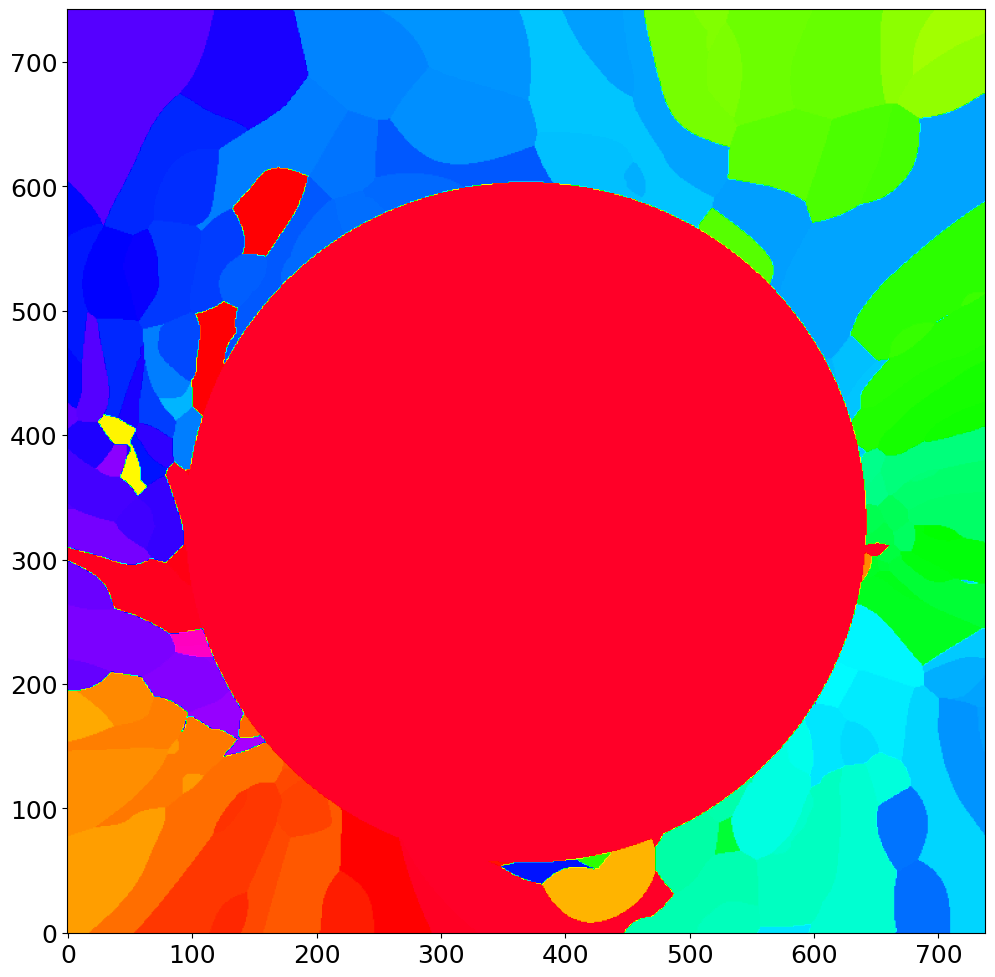

In [67]:
# This is a slice of the voxel label cube at a particular height with the limb mask applied,
# showing each loop as a different color
plt.imshow((limb_mask[:,:,75]*loopids[:,:,75] % 200).T, origin='lower',cmap=plt.get_cmap('gist_rainbow'))

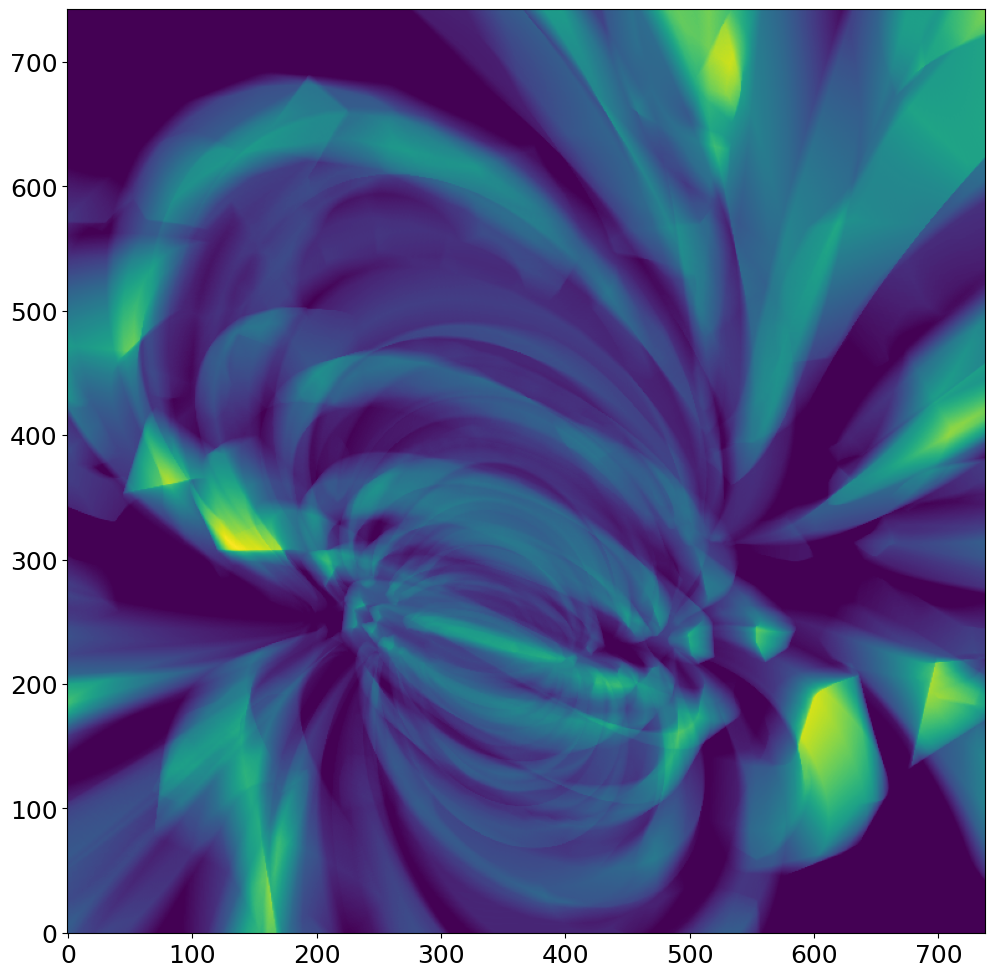

In [68]:
# This is a sum through the cube with every 5th loop illuminated:
plt.imshow(np.sum(limb_mask*(loopids % 5 == 0),axis=2).T)

In [69]:
# Crop the data for the reconstruction in a bit compared to the cube. This improves the ability of the 
# reconstruction to fit the data, although it does also mean that the edges of the reconstruction are 
# underconstrained. 
cropr = cropr0+np.array([10,-10,10,-10])*u.arcsec

# Compute the forward matrix from the field-aligned regions to the data:
[amat,modelinputs] = compute_fwdmat(aiadat_path, None, loopids, loopid_info,
                                    vox_grid, cropr, magnetogram, voxel_loop_lengths, curvature=False, 
                                    vox_mask=limb_mask, xpo1 = chan1_xpo, xpo2 = chan1_xpo, temp1=scaltemp1, 
                                    psf_size_px=0.4, zmin=np.min(mag_coords[2]), temp2=scaltemp2, asym=True)

Memory usage: 4237908 (kb)
8.979278
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2021-12-27T01:59:37.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (3.1313164, 22.31229192, 1.47125461e+11)>): (x, y, z) in cm
    (-1.54812419e+10, -1.3849476e+10, 6.54947691e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2021-12-27T01:59:37.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (3.1313164, 22.31229192, 1.47125461e+11)>): (x, y, z) in cm
    (1.54727581e+10, -1.3849476e+10, 6.54947691e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2021-12-27T01:59:37.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (3.1313164, 22.31229192, 1.47125461e+11)>): (x, y, z) in cm
    (-1.54812419e+10, 1.7314524e+10, 6.54947691e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2

Slice  126  of  460 22.84281897544861 Using: 4237908 kb
Slice  127  of  460 23.17300271987915 Using: 4237908 kb
Slice  128  of  460 23.494041919708252 Using: 4237908 kb
Slice  129  of  460 23.832936763763428 Using: 4237908 kb
Slice  130  of  460 24.169174432754517 Using: 4237908 kb
Slice  131  of  460 24.511939525604248 Using: 4237908 kb
Slice  132  of  460 24.83950424194336 Using: 4237908 kb
Slice  133  of  460 25.170931577682495 Using: 4237908 kb
Slice  134  of  460 25.52088975906372 Using: 4237908 kb
Slice  135  of  460 25.873156785964966 Using: 4237908 kb
Slice  136  of  460 26.2235586643219 Using: 4237908 kb
Slice  137  of  460 26.577070236206055 Using: 4237908 kb
Slice  138  of  460 26.951393842697144 Using: 4237908 kb
Slice  139  of  460 27.307426691055298 Using: 4237908 kb
Slice  140  of  460 27.64342737197876 Using: 4237908 kb
Slice  141  of  460 28.046728134155273 Using: 4237908 kb
Slice  142  of  460 28.394840002059937 Using: 4237908 kb
Slice  143  of  460 28.742666006088257

Slice  272  of  460 84.51966094970703 Using: 4237908 kb
Slice  273  of  460 85.00992059707642 Using: 4237908 kb
Slice  274  of  460 85.50582838058472 Using: 4237908 kb
Slice  275  of  460 85.98399353027344 Using: 4237908 kb
Slice  276  of  460 86.48319816589355 Using: 4237908 kb
Slice  277  of  460 86.96561241149902 Using: 4237908 kb
Slice  278  of  460 87.49667429924011 Using: 4237908 kb
Slice  279  of  460 88.00355982780457 Using: 4237908 kb
Slice  280  of  460 88.49260187149048 Using: 4237908 kb
Slice  281  of  460 89.02458453178406 Using: 4237908 kb
Slice  282  of  460 89.53757834434509 Using: 4237908 kb
Slice  283  of  460 90.0379593372345 Using: 4237908 kb
Slice  284  of  460 90.54387259483337 Using: 4237908 kb
Slice  285  of  460 91.02797889709473 Using: 4237908 kb
Slice  286  of  460 91.51312041282654 Using: 4237908 kb
Slice  287  of  460 92.02144455909729 Using: 4237908 kb
Slice  288  of  460 92.52194571495056 Using: 4237908 kb
Slice  289  of  460 93.04304099082947 Using: 4237

Slice  417  of  460 162.9845325946808 Using: 4237908 kb
Slice  418  of  460 163.5653944015503 Using: 4237908 kb
Slice  419  of  460 164.16038966178894 Using: 4237908 kb
Slice  420  of  460 164.75762295722961 Using: 4237908 kb
Slice  421  of  460 165.33701467514038 Using: 4237908 kb
Slice  422  of  460 165.93397188186646 Using: 4237908 kb
Slice  423  of  460 166.52645921707153 Using: 4237908 kb
Slice  424  of  460 167.12062287330627 Using: 4237908 kb
Slice  425  of  460 167.71174597740173 Using: 4237908 kb
Slice  426  of  460 168.28961992263794 Using: 4237908 kb
Slice  427  of  460 168.85665702819824 Using: 4237908 kb
Slice  428  of  460 169.4380338191986 Using: 4237908 kb
Slice  429  of  460 170.04177117347717 Using: 4237908 kb
Slice  430  of  460 170.6403365135193 Using: 4237908 kb
Slice  431  of  460 171.2289915084839 Using: 4237908 kb
Slice  432  of  460 171.8358862400055 Using: 4237908 kb
Slice  433  of  460 172.41795563697815 Using: 4237908 kb
Slice  434  of  460 172.99152135849 U

In [70]:
# Error estimates for the reconstruction:
chan1_err = estimate_aia_error(modelinputs['map'], channel = 'AIA'+modelinputs['map'].meta['wave_str'])

# Reconstruct using the forward matrix:
solution = reconstruct(amat, modelinputs, reg_fac=0.15, dat_xpo=1, errs=chan1_err, solver_tol=1.0e-5)

1.18 7.089739064309772 82.0
Overall regularization factor: 7.229162662333235e-05
1849.5672357960434 1849.5672357960434 7.522706964110543 7.522706964110543
8.69 s i = 0 chi2 = 4.94 step size = 0.5 reg. param. = 0.1 chi2 change = 4.8571 reg. change = -0.04691
0 7.471134210802266 0.6352360723540953 5.601698146314305 10.638661635720146
1849.5672357960434 1849.5672357960434 5.601698146314305 10.638661635720146
17.51 s i = 1 chi2 = 1.61 step size = 0.85 reg. param. = 0.07 chi2 change = 3.32933 reg. change = 0.03147
1 6.9938177490863165 1.1811630173571834 0.07547868446535144 10.061628392791764
1849.5672357960434 1849.5672357960434 0.07547868446535144 10.061628392791764
28.23 s i = 2 chi2 = 0.97 step size = 0.85 reg. param. = 0.06 chi2 change = 0.63712 reg. change = 0.00822
2 6.456373302472035 1.899471553482575 -6.785087674135239 9.681518249518112
1849.5672357960434 1849.5672357960434 -6.785087674135239 9.681518249518112
35.47 s i = 3 chi2 = 0.83 step size = 0.85 reg. param. = 0.06 chi2 change

In [71]:
# The product of the field-aligned region solution vector and the forward matrix is the reconstruction's estimate
# of the AIA image. amat and the solution use a scaled version of the matrix which greatly improves convergence of 
# Krylov methods, hence the loop_weights factors. For a single forward matrix rescaling by the loop weights below
# isn't necessary, but for multiple forward matrices (e.g., multiple perspectives) it is:
soln = copy.deepcopy(solution[0])/modelinputs['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(modelinputs['loop_weights']*soln)).reshape(modelinputs['map'].data.shape)

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

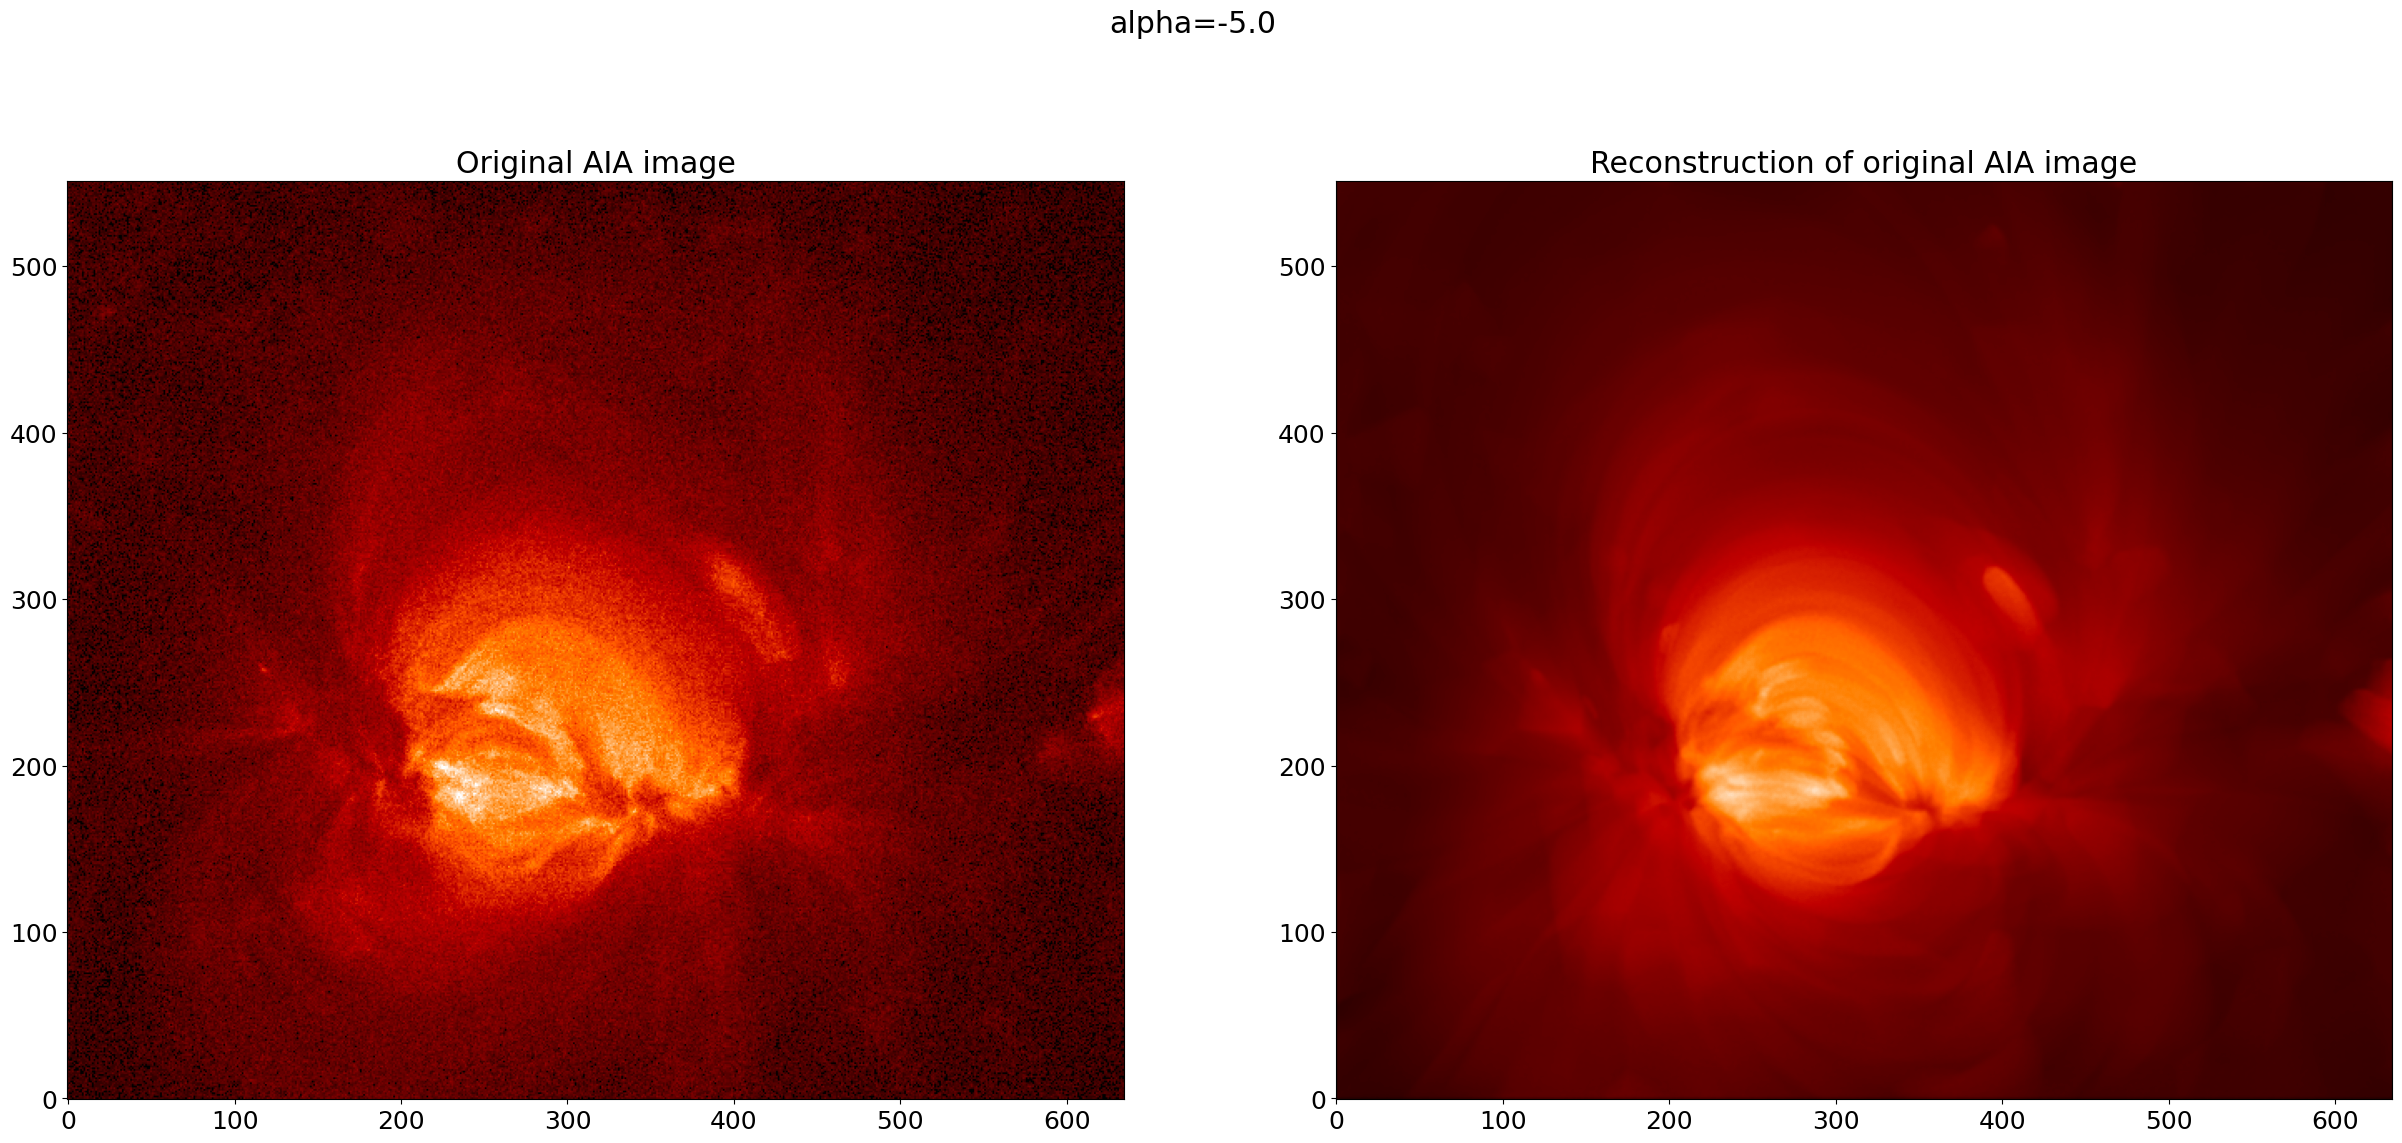

In [72]:
pltmax = 75

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[30,13])
plt.suptitle('alpha='+alphastr)
axes[0].imshow(np.abs(modelinputs['map'].data)**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [73]:
# Expand the solution into a 3D emission cube: 
em3d = get_3d_emission(solution[0], modelinputs, vox_grid, loopids, voxel_loop_lengths, loopid_info, zmin=np.min(mag_coords[2]))

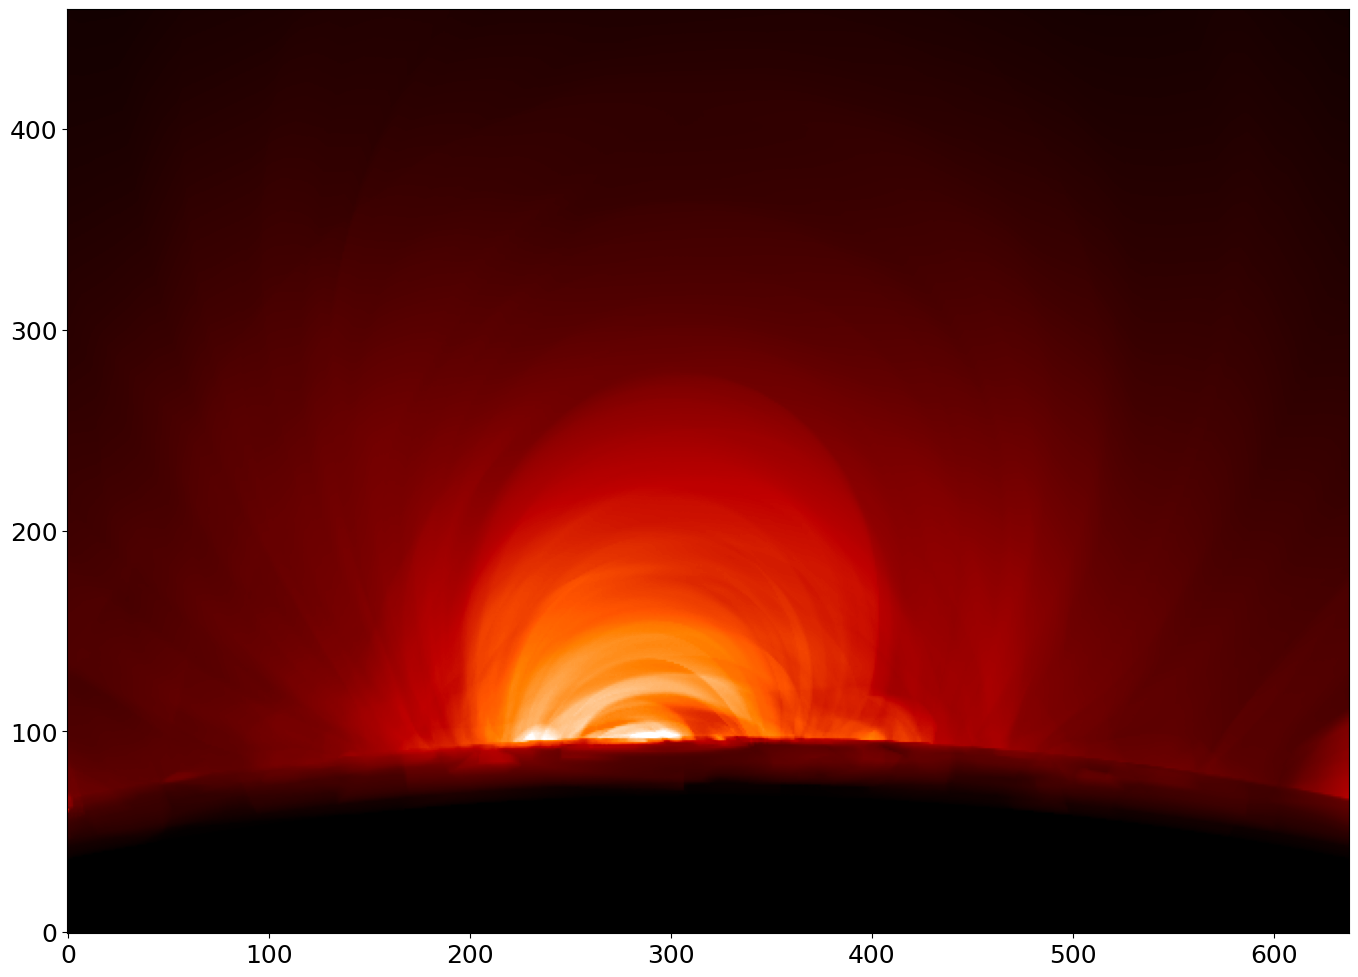

In [40]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from the pole):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=1).T**gfac,vmin=0,vmax=3.0e-6**gfac,cmap=plt.get_cmap('gist_heat'))

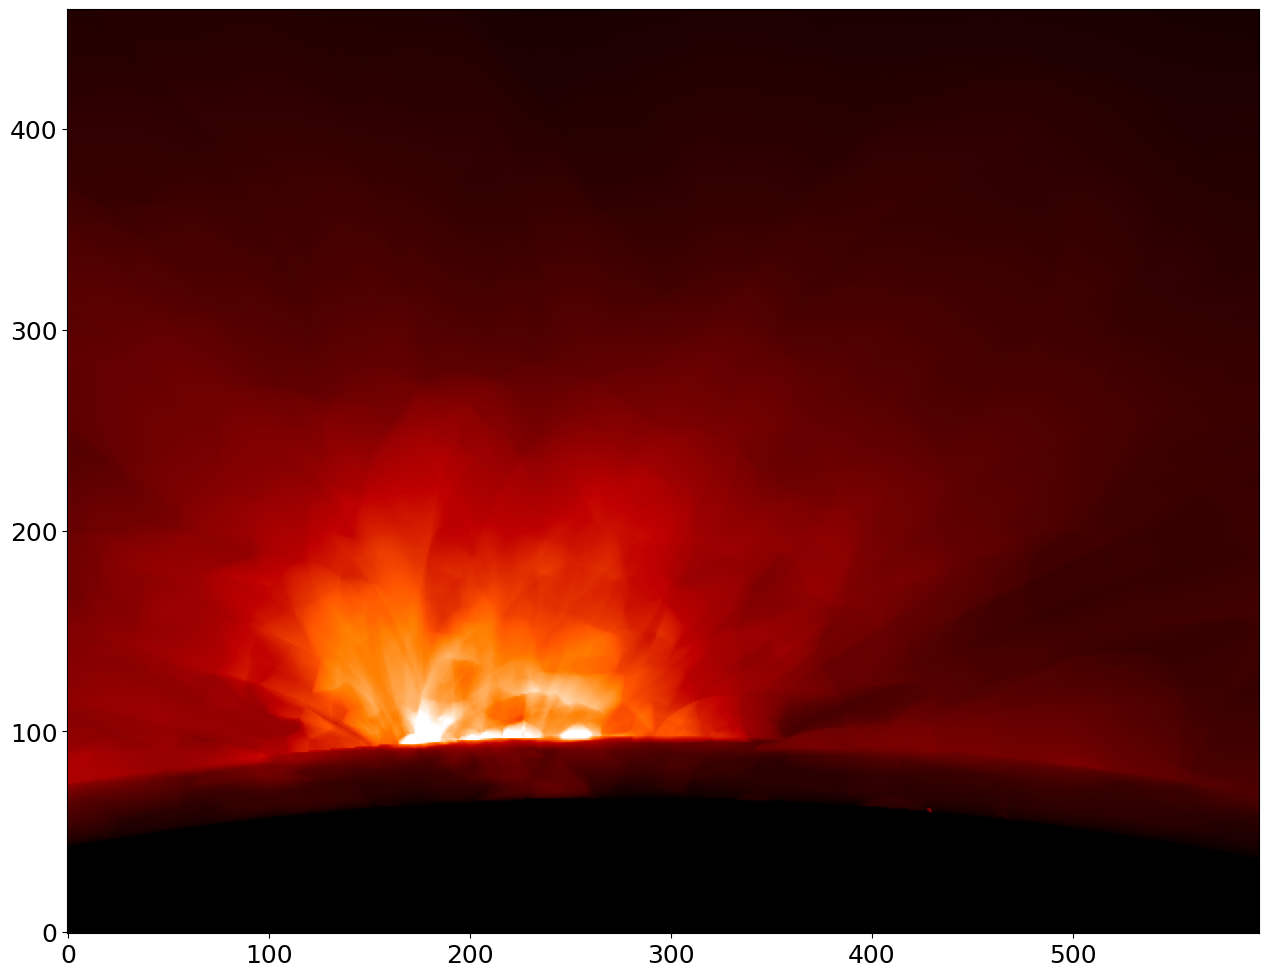

In [41]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from ecliptic latitude):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=0).T**gfac,vmin=0,vmax=3.0e-6**gfac,cmap=plt.get_cmap('gist_heat'))

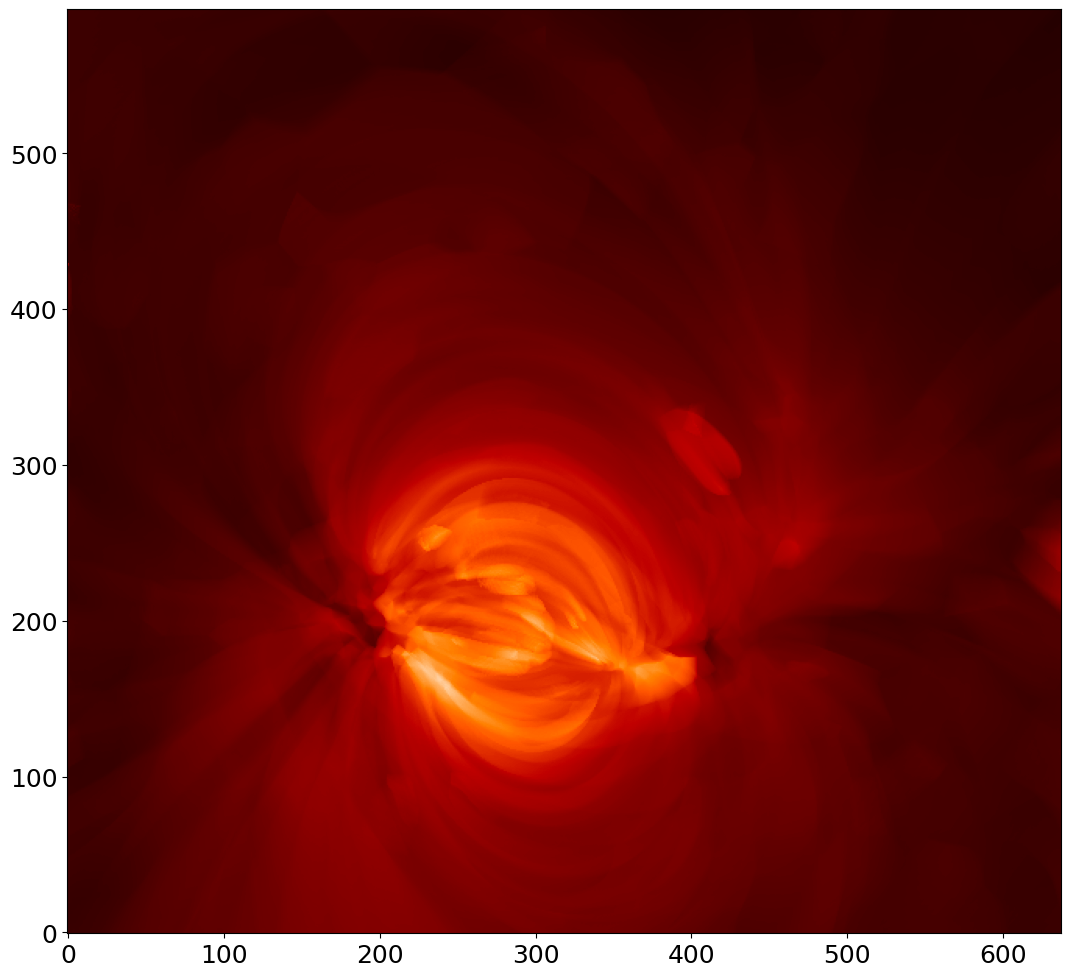

In [42]:
# Plot the x-y projection through the cube (e.g., as viewed from directly overhead):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=2).T**gfac,vmin=0,vmax=2.0e-6**gfac,cmap=plt.get_cmap('gist_heat'))